In [1]:
%pylab inline

from pylab import *
import pandas as pd
from pymc3 import * 
from pymc3.distributions.timeseries import *

Populating the interactive namespace from numpy and matplotlib


Data
----

In [2]:
data = pd.read_csv(get_data_file('pymc3.examples', '../data/pancreatitis.csv'))
countries = ['CYP', 'DNK', 'ESP', 'FIN','GBR', 'ISL']
data = data[data.area.isin(countries)]

age = data['age'] = np.array(data.age_start + data.age_end)/2
rate = data.value = data.value*1000
group, countries = pd.factorize(data.area)


ncountries = len(countries)

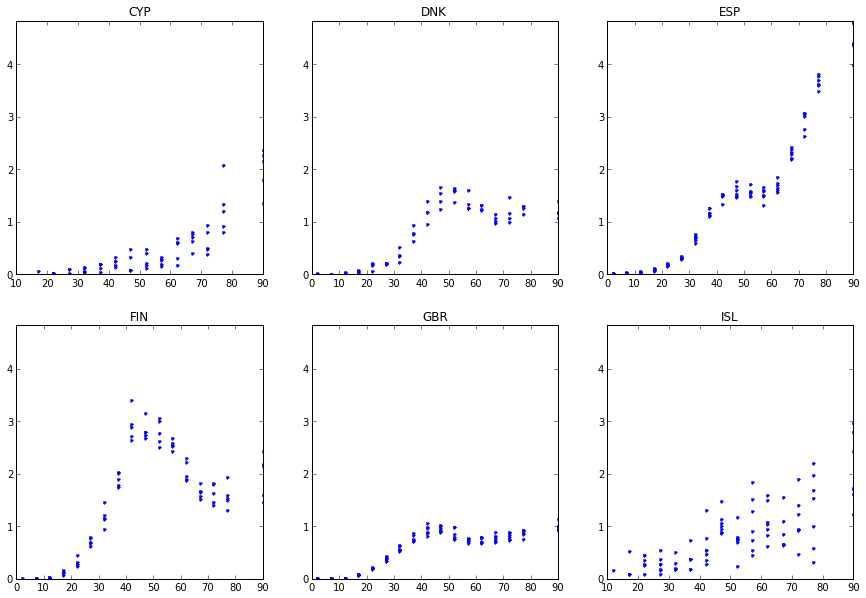

In [3]:
figsize(15,10)
for i, country in enumerate(countries):
    subplot(2,3,i+1)
    title(country)
    d = data[data.area == country]
    plot(d.age, d.value, '.')
    
    ylim(0,rate.max())

Model Specification
-------------------

In [4]:
nknots = 10
knots = np.linspace(data.age_start.min(),data.age_end.max(), nknots)


def interpolate(x0,y0, x, group):
    x = np.array(x)
    group = np.array(group)
    
    idx = np.searchsorted(x0, x)
    dl = np.array(x - x0[idx - 1])
    dr = np.array(x0[idx] - x)
    d=dl+dr
    wl = dr/d

    return wl*y0[idx-1, group] + (1-wl)*y0[idx, group]
    

with Model() as model:
    coeff_sd = StudentT('coeff_sd', 10, 1, 5**-2)
        
    y = GaussianRandomWalk('y', sd=coeff_sd, shape = (nknots, ncountries))
    
    p = interpolate(knots, y, age, group)
    
    sd = StudentT('sd', 10, 2, 5**-2)
    
    vals = Normal('vals', p, sd=sd, observed = rate)

Model Fitting
-------------

In [5]:
with model:
    s = find_MAP( vars=[sd, y])
    
    step = NUTS(scaling = s)
    trace = sample(100, step, s)
    
    s = trace[-1]
    
    step = NUTS(scaling = s)
    trace = sample(3000, step, s)
    

 [-----------------100%-----------------] 3000 of 3000 complete in 29.0 sec

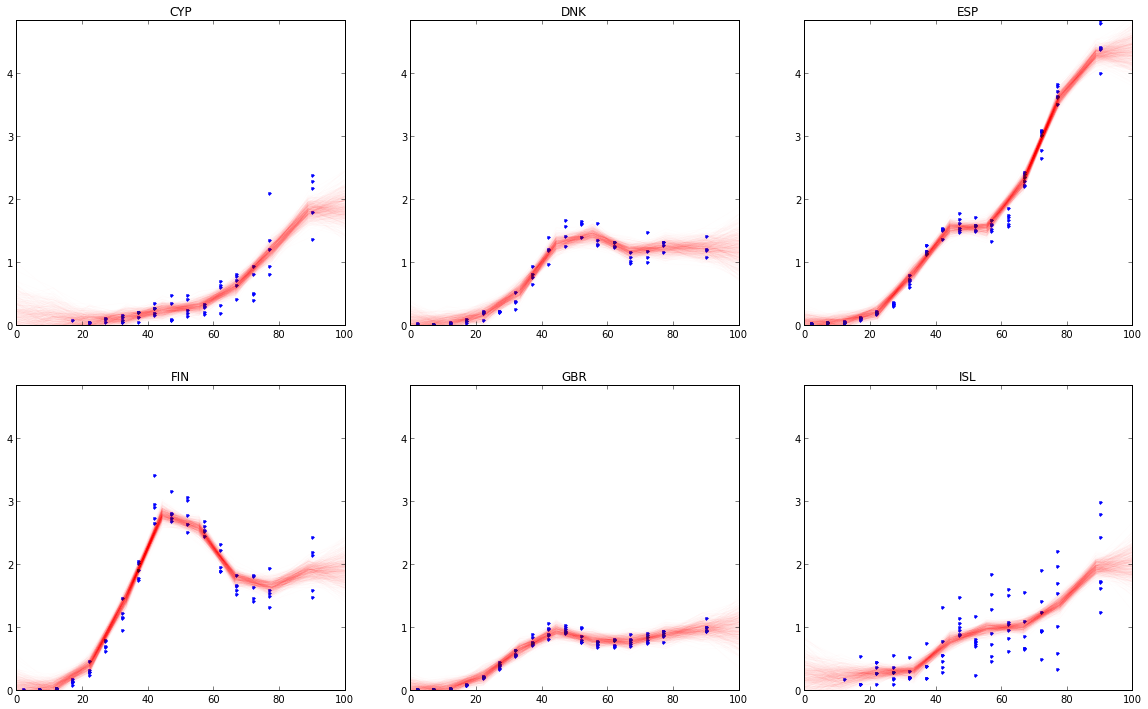

In [6]:
figsize(20,12)
for i, country in enumerate(countries):
    subplot(2,3,i+1)
    title(country)
    
    d = data[data.area == country]
    plot(d.age, d.value, '.')
    plot(knots, trace[y][::5,:,i].T, color ='r', alpha =.01);
    
    ylim(0,rate.max())

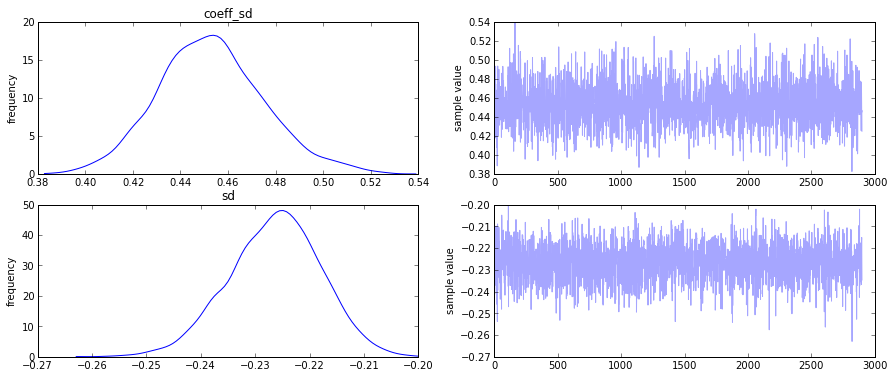

In [8]:
figsize(15, 6)
traceplot(trace[100:], vars = [coeff_sd,sd ]);

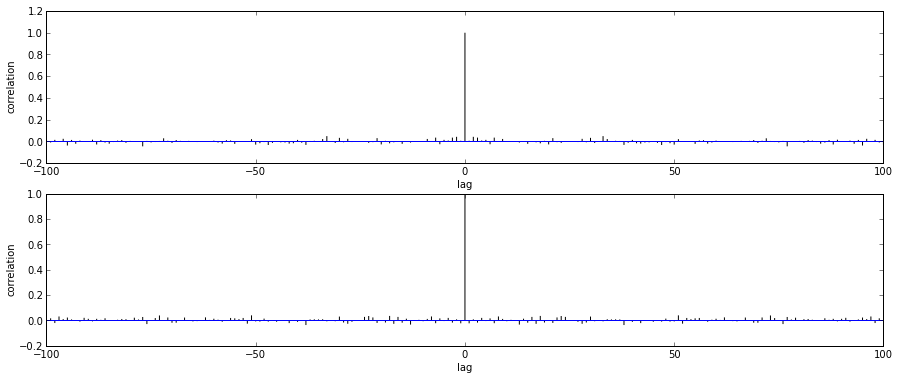

In [11]:
autocorrplot(trace, varnames = [coeff_sd,sd ])